In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from pprint import pprint
from scipy.stats import linregress
from datetime import datetime

%matplotlib inline

# Impor the OpenWeatherMap API key
from config import api_key


In [2]:
#Variables used in API call, oldest date is furthest back we are willing to go
oldest_date = "2014-01-31"
company_symbols = ["TAN",
                    "ENPH",
                    "SEDG",
                    "FSLR",
                    "HYDR",
                    "PLUG",
                    "BLDP",
                    "BE",
                    "FAN",
                    "TAC",
                    "TPIC",
                    "AMSC"]
time_function = "TIME_SERIES_MONTHLY"
base_url = "https://www.alphavantage.co/query?"

company_data = []

for symbol in company_symbols:
    finished_url = f"{base_url}function={time_function}&symbol={symbol}&apikey={api_key}"
    print(f"Processing {symbol}")

    result_data = requests.get(finished_url).json()
    print(result_data)

    time.sleep(1)

    for monthly in result_data["Monthly Time Series"]:
        monthly_date = time.strptime(monthly, "%Y-%m-%d")
        oldest = time.strptime(oldest_date, "%Y-%m-%d")
        if (monthly_date < oldest):
            continue
        stock_date = monthly
        stock_close = result_data["Monthly Time Series"][monthly]["4. close"]
        company_data.append({"Symbol":symbol,
                            "Date":stock_date,
                            "Closing Price":stock_close})

company_data_df = pd.DataFrame(company_data)
company_data_df


Processing TAN
{'Information': 'Thank you for using Alpha Vantage! Our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.'}


KeyError: 'Monthly Time Series'

In [3]:
#Read data from the saved CSV file and sort it by symbol and date
read_data_df = pd.read_csv("data/company_data.csv", index_col="Stock_ID")
ordered_data_df = read_data_df.sort_values(by=["Symbol", "Date"])
ordered_data_df

,Symbol,Date,Closing Price,Type
Stock_ID,,,,
1355,AMSC,2014-01-31,1.50,Wind
1354,AMSC,2014-02-28,1.85,Wind
1353,AMSC,2014-03-31,1.61,Wind
1352,AMSC,2014-04-30,1.28,Wind
1351,AMSC,2014-05-30,1.40,Wind
...,...,...,...,...
1133,TPIC,2024-05-31,5.48,Wind
1132,TPIC,2024-06-28,3.99,Wind
1131,TPIC,2024-07-31,4.26,Wind


In [4]:
print(ordered_data_df.columns)
# Define the stock symbols for each sector
solar_symbols = ["TAN", "ENPH", "SEDG", "FSLR"]
hydrogen_symbols = ["BLDP", "PLUG", "BE", "HYDR"]
wind_symbols = ["FAN", "TAC", "TPIC", "AMSC"]

#creating a data frame for each of the types
solar_symbols_df = ordered_data_df[ordered_data_df['Type'] == 'Solar']
solar_symbols_df.head()


Index(['Symbol', 'Date', 'Closing Price', 'Type'], dtype='object')


,Symbol,Date,Closing Price,Type
Stock_ID,,,,
257,ENPH,2014-01-31,7.40,Solar
256,ENPH,2014-02-28,8.07,Solar
255,ENPH,2014-03-31,7.36,Solar
254,ENPH,2014-04-30,7.55,Solar
253,ENPH,2014-05-30,8.45,Solar


In [5]:
#creating the wind data frames
wind_symbols_df = ordered_data_df[ordered_data_df['Type'] == 'Wind']
wind_symbols_df.head()


,Symbol,Date,Closing Price,Type
Stock_ID,,,,
1355,AMSC,2014-01-31,1.50,Wind
1354,AMSC,2014-02-28,1.85,Wind
1353,AMSC,2014-03-31,1.61,Wind
1352,AMSC,2014-04-30,1.28,Wind
1351,AMSC,2014-05-30,1.40,Wind


In [6]:
hydrogen_symbols_df = ordered_data_df[ordered_data_df['Type'] == 'Hydrogen']
hydrogen_symbols_df.head()

,Symbol,Date,Closing Price,Type
Stock_ID,,,,
870,BE,2018-08-31,29.95,Hydrogen
869,BE,2018-09-28,34.08,Hydrogen
868,BE,2018-10-31,23.75,Hydrogen
867,BE,2018-11-30,16.45,Hydrogen
866,BE,2018-12-31,9.98,Hydrogen


C:\Users\16692\AppData\Local\Temp\ipykernel_125560\1664596156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_symbols_df['Returns'] = wind_symbols_df.groupby('Symbol')['Closing Price'].pct_change()
C:\Users\16692\AppData\Local\Temp\ipykernel_125560\1664596156.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_symbols_df['Volatility'] = wind_symbols_df.groupby('Symbol')['Returns'].rolling(window=window).std().reset_index(0, drop=True) * (252 ** 0.5)  # Annualized


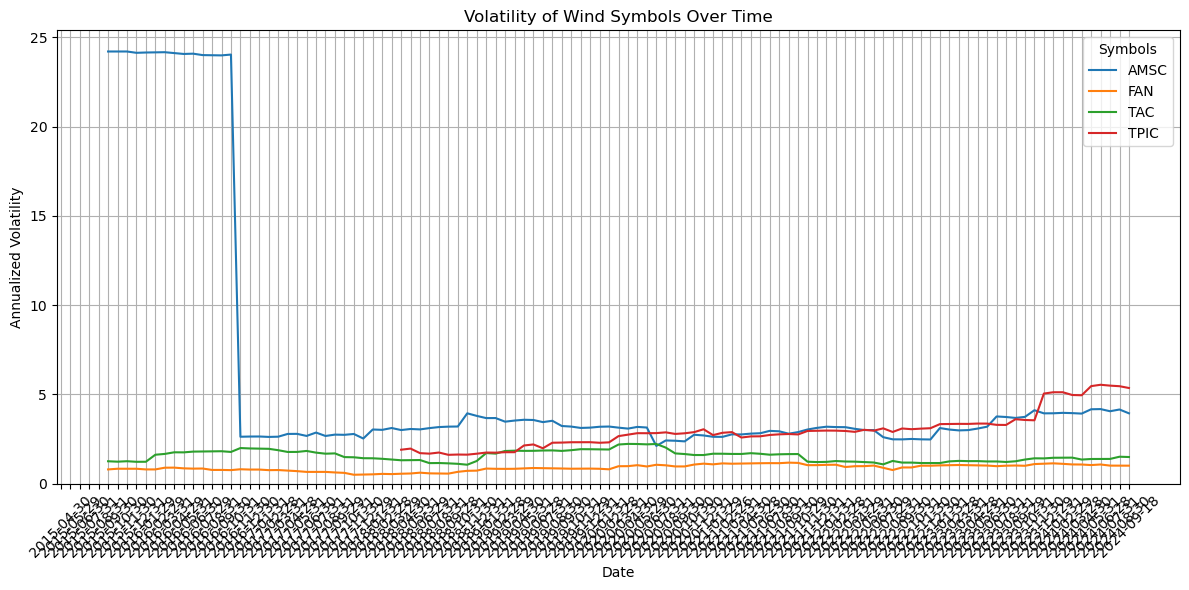

Symbol      AMSC  FAN  TAC  TPIC
Date                            
2014-01-31   NaN  NaN  NaN   NaN
2014-02-28   NaN  NaN  NaN   NaN
2014-03-31   NaN  NaN  NaN   NaN
2014-04-30   NaN  NaN  NaN   NaN
2014-05-30   NaN  NaN  NaN   NaN


In [7]:

# Calculate returns for each symbol
wind_symbols_df['Returns'] = wind_symbols_df.groupby('Symbol')['Closing Price'].pct_change()

# Calculate rolling volatility for each symbol (using a 20-day window)
window = 20
wind_symbols_df['Volatility'] = wind_symbols_df.groupby('Symbol')['Returns'].rolling(window=window).std().reset_index(0, drop=True) * (252 ** 0.5)  # Annualized

# Pivot the data to have one column per symbol
volatility_df = wind_symbols_df.pivot(index='Date', columns='Symbol', values='Volatility')


# Plotting
plt.figure(figsize=(12, 6))
for column in volatility_df.columns:
    plt.plot(volatility_df.index, volatility_df[column], label=column)

plt.title('Volatility of Wind Symbols Over Time')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend(title='Symbols', loc='upper right')
plt.xticks(rotation=45)
plt.ylim(bottom=0)  # Start y-axis at 0
plt.tight_layout()
plt.grid(True)
plt.show()

# If the plot doesn't show up in your environment, try saving it to a file
#plt.savefig('wind_symbols_volatility_line_plot.png')
#print("Plot saved as 'wind_symbols_volatility_line_plot.png'")

# If the plot doesn't show up in your environment, try saving it to a file
#plt.savefig('wind_symbols_volatility_plot.png')
#print("Plot saved as 'wind_symbols_volatility_plot.png'")

# Print the head of the volatility dataframe to check the data
print(volatility_df.head())

C:\Users\16692\AppData\Local\Temp\ipykernel_125560\926801424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_symbols_df['Returns'] = solar_symbols_df.groupby('Symbol')['Closing Price'].pct_change()
C:\Users\16692\AppData\Local\Temp\ipykernel_125560\926801424.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_symbols_df['Volatility'] = solar_symbols_df.groupby('Symbol')['Returns'].rolling(window=window).std().reset_index(0, drop=True) * (252 ** 0.5)  # Annualized


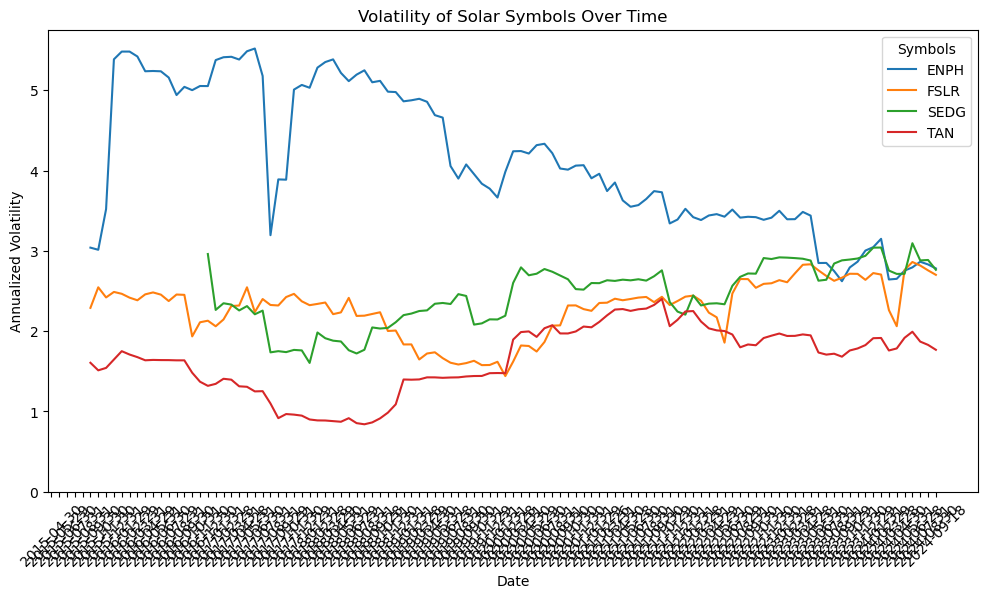

Symbol      ENPH  FSLR  SEDG  TAN
Date                             
2014-01-31   NaN   NaN   NaN  NaN
2014-02-28   NaN   NaN   NaN  NaN
2014-03-31   NaN   NaN   NaN  NaN
2014-04-30   NaN   NaN   NaN  NaN
2014-05-30   NaN   NaN   NaN  NaN


In [8]:
# Calculate returns for each symbol
solar_symbols_df['Returns'] = solar_symbols_df.groupby('Symbol')['Closing Price'].pct_change()

# Calculate rolling volatility for each symbol (using a 20-day window)
window = 20
solar_symbols_df['Volatility'] = solar_symbols_df.groupby('Symbol')['Returns'].rolling(window=window).std().reset_index(0, drop=True) * (252 ** 0.5)  # Annualized

# Pivot the data to have one column per symbol
volatility_df = solar_symbols_df.pivot(index='Date', columns='Symbol', values='Volatility')


# Plotting
plt.figure(figsize=(12, 6))
for column in volatility_df.columns:
    plt.plot(volatility_df.index, volatility_df[column], label=column)

plt.title('Volatility of Solar Symbols Over Time')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend(title='Symbols', loc='upper right')
plt.xticks(rotation=45)
plt.ylim(bottom=0)  # Start y-axis at 0
#plt.tight_layout()
#plt.grid(True)
plt.show()

# If the plot doesn't show up in your environment, try saving it to a file
#plt.savefig('wind_symbols_volatility_line_plot.png')
#print("Plot saved as 'wind_symbols_volatility_line_plot.png'")

# If the plot doesn't show up in your environment, try saving it to a file
#plt.savefig('wind_symbols_volatility_plot.png')
#print("Plot saved as 'wind_symbols_volatility_plot.png'")

# Print the head of the volatility dataframe to check the data
print(volatility_df.head())

C:\Users\16692\AppData\Local\Temp\ipykernel_125560\4204403913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hydrogen_symbols_df['Returns'] = hydrogen_symbols_df.groupby('Symbol')['Closing Price'].pct_change()
C:\Users\16692\AppData\Local\Temp\ipykernel_125560\4204403913.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hydrogen_symbols_df['Volatility'] = hydrogen_symbols_df.groupby('Symbol')['Returns'].rolling(window=window).std().reset_index(0, drop=True) * (252 ** 0.5)  # Annualized


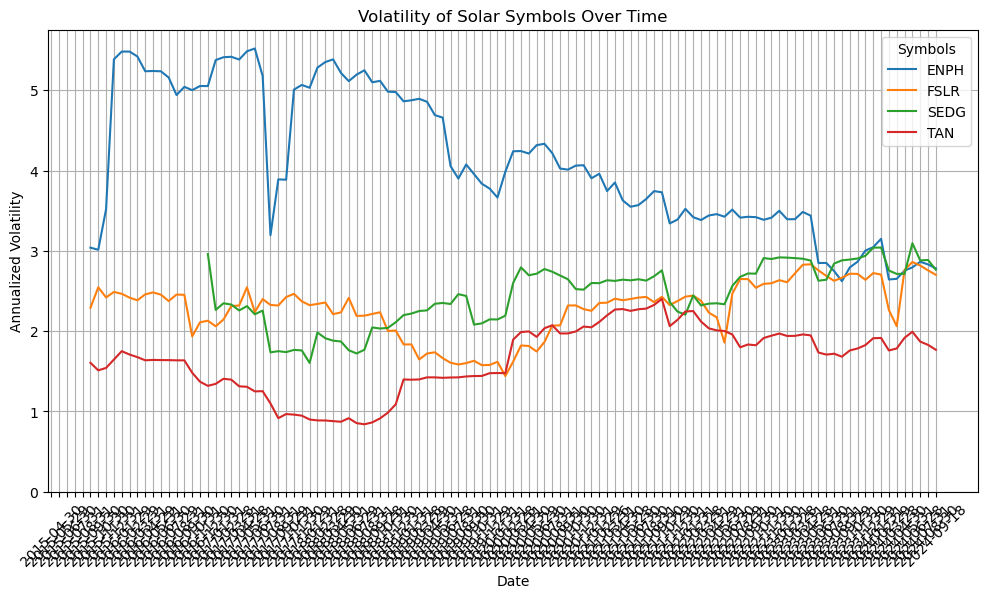

In [9]:
# Calculate returns for each symbol
hydrogen_symbols_df['Returns'] = hydrogen_symbols_df.groupby('Symbol')['Closing Price'].pct_change()

# Calculate rolling volatility for each symbol (using a 20-day window)
window = 20
hydrogen_symbols_df['Volatility'] = hydrogen_symbols_df.groupby('Symbol')['Returns'].rolling(window=window).std().reset_index(0, drop=True) * (252 ** 0.5)  # Annualized

# Pivot the data to have one column per symbol
volatility_df = solar_symbols_df.pivot(index='Date', columns='Symbol', values='Volatility')


# Plotting
plt.figure(figsize=(12, 6))
for column in volatility_df.columns:
    plt.plot(volatility_df.index, volatility_df[column], label=column)

plt.title('Volatility of Solar Symbols Over Time')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend(title='Symbols', loc='upper right')
plt.xticks(rotation=45)
plt.ylim(bottom=0)  # Start y-axis at 0
#plt.tight_layout()
plt.grid(True)
plt.show()


In [13]:
# Ensure that the 'Date' column is in datetime format
ordered_data_df['Date'] = pd.to_datetime(ordered_data_df['Date'])

yearly_std = []

# Get unique company symbols
company_symbols = ordered_data_df['Symbol'].unique()

for symbol in company_symbols:
    # Get the starting year for the current symbol
    starting_year = ordered_data_df[ordered_data_df["Symbol"] == symbol]["Date"].dt.year.min()
    
    for year in range(starting_year, 2025):
        # Filter data for the current symbol and year
        yearly_data = ordered_data_df[(ordered_data_df["Symbol"] == symbol) & (ordered_data_df["Date"].dt.year == year)]
        
        # Calculate the standard deviation of the 'Closing Price'
        std = yearly_data["Closing Price"].std()
        
        # Append the result
        yearly_std.append({
            "Symbol": symbol,
            "Year": year,
            "Std for year": std,
            "Type": ordered_data_df.loc[ordered_data_df["Symbol"] == symbol, "Type"].iloc[0]
        })

# Create a DataFrame from the results
yearly_std_df = pd.DataFrame(yearly_std)

# Display the resulting DataFrame
yearly_std_df


,Symbol,Year,Std for year,Type
0,AMSC,2014,0.355345,Wind
1,AMSC,2015,1.992948,Wind
2,AMSC,2016,1.257937,Wind
3,AMSC,2017,1.305376,Wind
4,AMSC,2018,1.944070,Wind
...,...,...,...,...
113,TPIC,2020,10.582643,Wind
114,TPIC,2021,14.278840,Wind
115,TPIC,2022,2.524080,Wind
116,TPIC,2023,4.454690,Wind


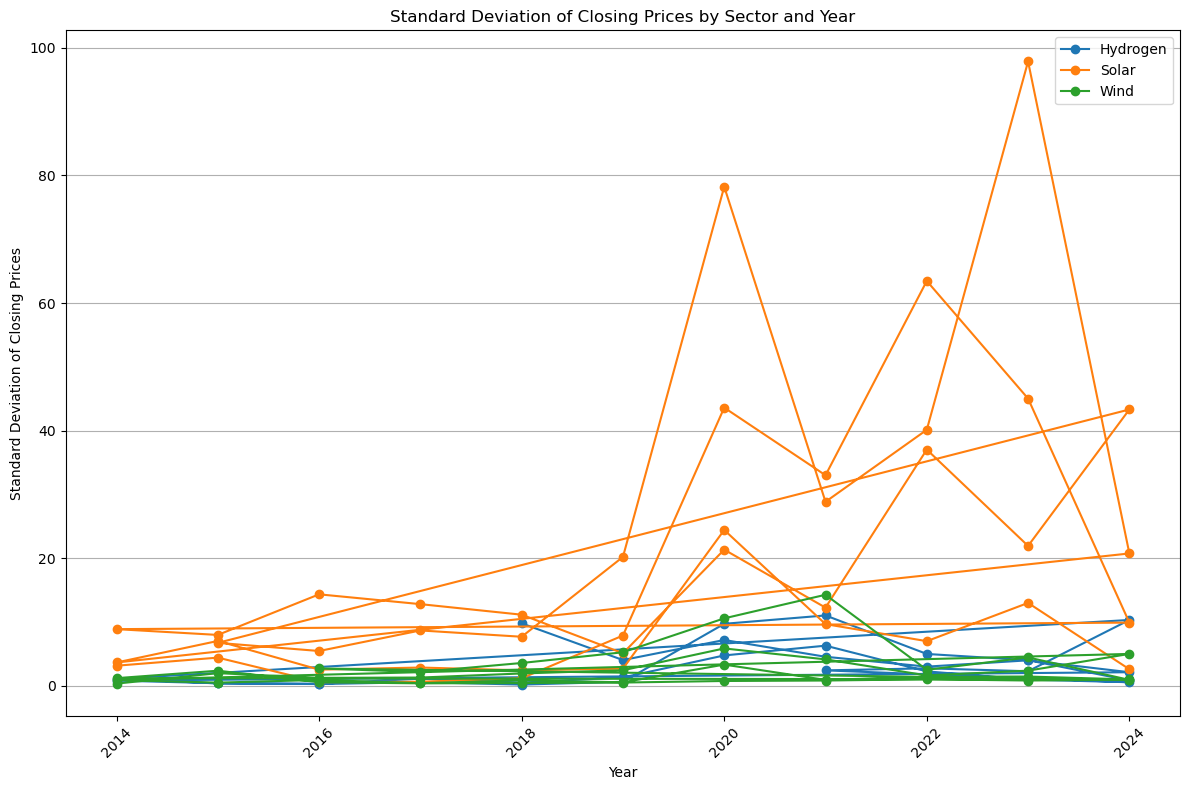

In [16]:
grouped_std = yearly_std_df.groupby(['Type', 'Symbol', 'Year'])['Std for year'].mean().reset_index()

# Set the figure size for the plots
plt.figure(figsize=(12, 8))

# Loop through each unique type and plot
for t in grouped_std['Type'].unique():
    # Filter the DataFrame for the current type
    type_df = grouped_std[grouped_std['Type'] == t]
    
    # Create a line plot for the current type
    plt.plot(type_df['Year'], type_df['Std for year'], marker='o', label=t)

# Adding titles and labels
plt.title('Standard Deviation of Closing Prices by Sector and Year')
plt.xlabel('Year')
plt.ylabel('Standard Deviation of Closing Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(axis='y')

# Show the plot
plt.show()


In [5]:

# Sort the data by Symbol and Date
ordered_data_df = read_data_df.sort_values(by=["Symbol", "Date"])
print(ordered_data_df)

# Calculate daily returns
ordered_data_df['Return'] = ordered_data_df.groupby('Symbol')['Closing Price'].pct_change()

# Calculate volatility (standard deviation of returns) for each sector/type
volatility_df = ordered_data_df.groupby('Type')['Return'].std().reset_index()
print(volatility_df)

# Rename the columns for clarity
volatility_df.columns = ['Type', 'Volatility']



         Symbol       Date  Closing Price  Type
Stock_ID                                       
1355       AMSC 2014-01-31           1.50  Wind
1354       AMSC 2014-02-28           1.85  Wind
1353       AMSC 2014-03-31           1.61  Wind
1352       AMSC 2014-04-30           1.28  Wind
1351       AMSC 2014-05-30           1.40  Wind
...         ...        ...            ...   ...
1133       TPIC 2024-05-31           5.48  Wind
1132       TPIC 2024-06-28           3.99  Wind
1131       TPIC 2024-07-31           4.26  Wind
1130       TPIC 2024-08-30           4.33  Wind
1129       TPIC 2024-09-18           4.37  Wind

[1356 rows x 4 columns]
       Type    Return
0  Hydrogen  0.277191
1     Solar  0.181030
2      Wind  0.342261


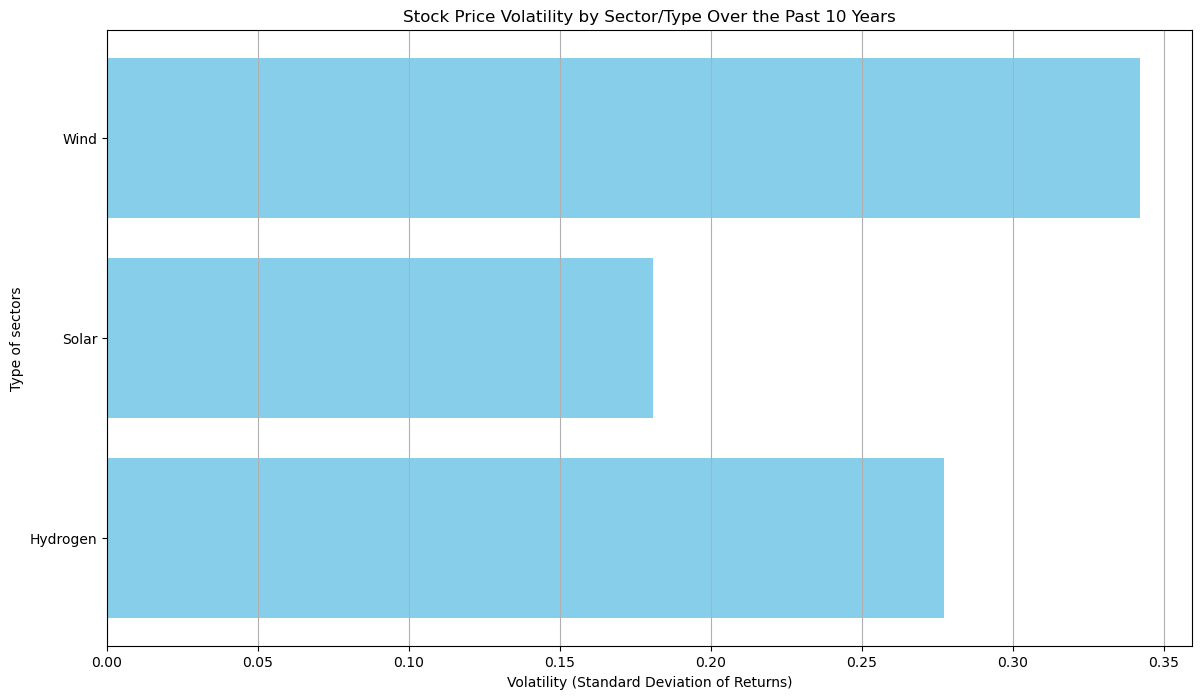

In [8]:
# Plotting
plt.figure(figsize=(14, 8))
plt.barh(volatility_df['Type'], volatility_df['Volatility'], color='skyblue')
plt.xlabel('Volatility (Standard Deviation of Returns)')
plt.ylabel('Type of sectors')
plt.title('Stock Price Volatility by Sector/Type Over the Past 10 Years')
plt.grid(axis='x')
plt.show()
